In [1]:
#######################################################
#Title: Daily sale prediction using machine learning ##
#Author: Pair Phongphaew, Salma EL HASSANI           ##
#Date : Feb 14, 2023                                 ##
#######################################################

In [7]:
import pandas as pd 
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime as dt   # To access datetime 
from pandas import Series        # To work on series 


In [12]:
xls = pd.ExcelFile('online_retail_II.xlsx')
df1 = pd.read_excel(xls, 'Year 2009-2010')
df2 = pd.read_excel(xls, 'Year 2010-2011')

In [13]:
print(df1.keys())
print(df2.keys())

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [14]:
#Find the country that has the most transactions 
group_country_df1 = df1.groupby("Country").count().sort_values(by=['Invoice'],ascending=False)
group_country_df2 = df2.groupby("Country").count().sort_values(by=['Invoice'],ascending=False)
print(group_country_df1.head(2))
print(group_country_df2.head(2))

                Invoice  StockCode  Description  Quantity  InvoiceDate  \
Country                                                                  
United Kingdom   485852     485852       482924    485852       485852   
EIRE               9670       9670         9670      9670         9670   

                 Price  Customer ID  
Country                              
United Kingdom  485852       379423  
EIRE              9670         8710  
                Invoice  StockCode  Description  Quantity  InvoiceDate  \
Country                                                                  
United Kingdom   495478     495478       494024    495478       495478   
Germany            9495       9495         9495      9495         9495   

                 Price  Customer ID  
Country                              
United Kingdom  495478       361878  
Germany           9495         9495  


Comment: the data in the United Kingdom is big enough to forcast so we are going to focus on the sales throughout the years in this country 

In [15]:
d_UK1 = df1[df1['Country'] == 'United Kingdom']
d_UK2 = df2[df2['Country'] == 'United Kingdom']
#calculate Total = Quantity*Price (total sales)
d_UK1_new = d_UK1.copy() 
d_UK2_new = d_UK2.copy() 
d_UK1_new["total"] = d_UK1["Quantity"]*d_UK1["Price"]
d_UK2_new["total"] = d_UK2["Quantity"]*d_UK2["Price"]
#now drop unneccessay columns 
d_UK1_new = d_UK1_new.drop(['Invoice','Country','Description','Price','Quantity','Customer ID'],axis =1).dropna(axis=0)
d_UK2_new = d_UK2_new.drop(['Invoice','Country','Description','Price','Quantity','Customer ID'],axis =1).dropna(axis=0)



In [16]:
#concat d_UK1 and d_UK2 
frames = [d_UK1_new,d_UK2_new]
d_all = pd.concat(frames,ignore_index=True) #Year 2009 to 2011 
#print(d_all.tail(5))
# InvoiceDate to date only
d_all['InvoiceDate'] = pd.to_datetime(d_all.InvoiceDate)
#print(d_all)

#extract the Year-Month-Day-Hour 
d_all['Year'] = d_all.InvoiceDate.dt.year
d_all['Month'] = d_all.InvoiceDate.dt.month
d_all['Day'] = d_all.InvoiceDate.dt.day
d_all['Hour'] = d_all.InvoiceDate.dt.hour


 

After looking at the data, we are going to predict the daily sales in United Kingdom

EDA

Hypothesis
1. the avg sales will be high during the end of the year
2. Sale is high around the beginning of the month

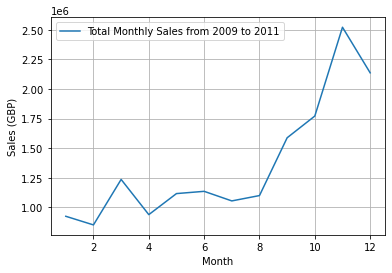

In [17]:
sales_per_month = d_all.groupby('Month')['total'].sum()
plt.plot(sales_per_month)
plt.ylabel('Sales (GBP)')
plt.xlabel('Month')
plt.legend(['Total Monthly Sales from 2009 to 2011'])
plt.grid(True)

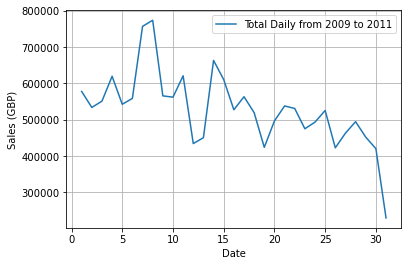

In [18]:
sales_per_day = d_all.groupby('Day')['total'].sum()
plt.plot(sales_per_day) 
plt.ylabel('Sales (GBP)')
plt.xlabel('Date')
plt.legend(['Total Daily from 2009 to 2011'])
plt.grid(True)

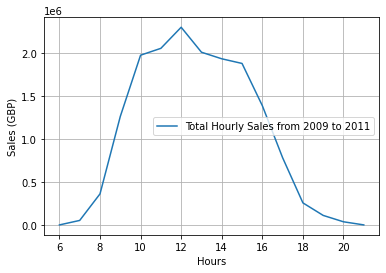

In [19]:
sales_per_hour = d_all.groupby('Hour')['total'].sum()
plt.plot(sales_per_hour) 
plt.ylabel('Sales (GBP)')
plt.xlabel('Hours')
plt.legend(['Total Hourly Sales from 2009 to 2011'])
plt.grid(True)

Spliting data for training and testing

In [20]:
#print(d_all)
X = d_all.copy()
X = X.set_index('InvoiceDate')
#X = X.drop(['StockCode','Year','Month','Day','Hour'],axis =1)
print(X)

                    StockCode  total  Year  Month  Day  Hour
InvoiceDate                                                 
2009-12-01 07:45:00     85048   83.4  2009     12    1     7
2009-12-01 07:45:00    79323P   81.0  2009     12    1     7
2009-12-01 07:45:00    79323W   81.0  2009     12    1     7
2009-12-01 07:45:00     22041  100.8  2009     12    1     7
2009-12-01 07:45:00     21232   30.0  2009     12    1     7
...                       ...    ...   ...    ...  ...   ...
2011-12-09 12:31:00     22466   23.4  2011     12    9    12
2011-12-09 12:49:00     22061   23.6  2011     12    9    12
2011-12-09 12:49:00     23275   30.0  2011     12    9    12
2011-12-09 12:49:00     21217  214.8  2011     12    9    12
2011-12-09 12:49:00     20685   70.8  2011     12    9    12

[981330 rows x 6 columns]


Resample the total sales by day and drop the day that has zero sale

In [21]:
#resample TOTAL OF THE SAME YEAR-MONTH-DAY
temp = X.total.resample('D').sum()
daily_resampled=temp.to_frame('total')
#print(daily_resampled[daily_resampled['total']==0])
daily_resampled.drop(daily_resampled.loc[daily_resampled['total']==0].index, inplace=True)


                total
InvoiceDate          
2009-12-01   46692.71
2009-12-02   55871.42
2009-12-03   67340.80
2009-12-04   37828.33
2009-12-05    9042.36
...               ...
2011-12-05   54715.25
2011-12-06   50307.31
2011-12-07   55028.58
2011-12-08   78437.90
2011-12-09   27345.03

[604 rows x 1 columns]


Text(0, 0.5, 'total sales (GBP)')

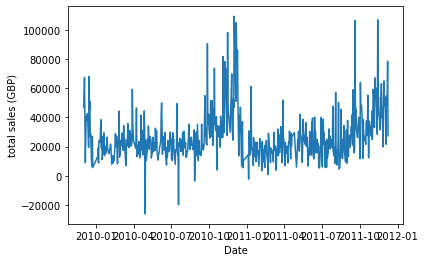

In [22]:
print(daily_resampled)

plt.plot(daily_resampled)
plt.xlabel('Date')
plt.ylabel('total sales (GBP)')

In [23]:
from sklearn.metrics import mean_absolute_percentage_error

In [24]:
# extract the seasonality data
months = [x.month for x in daily_resampled.index]
years = [x.year for x in daily_resampled.index]
day = [x.day for x in daily_resampled.index]

# convert into one matrix
X = np.array([day, months, years]).T
y = daily_resampled.total.values
X_train, y_train = X[:450],y[:450]
X_test, y_test = X[450:], y[450:]

After we resampled by day, we have 604 samples and the first 450 samples are going to be our training data. The rest will be our test data

In [25]:
from datetime import datetime
import time
def x_to_datetime(x):
    date = []
    for i in range(len(x)):
        day = x[i][0]
        month = x[i][1]
        year = x[i][2]
        time_obj = datetime(year,month,day)
        date_str = time_obj.strftime("%Y-%m-%d")
        date.append(date_str)
    return date


In [26]:
X_train_axis = pd.DataFrame(x_to_datetime(X_train)).set_index(0)
X_test_axis = pd.DataFrame(x_to_datetime(X_test)).set_index(0)

In [27]:
from sklearn.linear_model import LinearRegression

my_lr = LinearRegression()
my_lr.fit(X_train, y_train)

# predict on the same period
preds = my_lr.predict(X_train)
mape = mean_absolute_percentage_error(y_train,preds)
print('mean absolute percentage error:',mape)


mean absolute percentage error: 0.5721352170388867


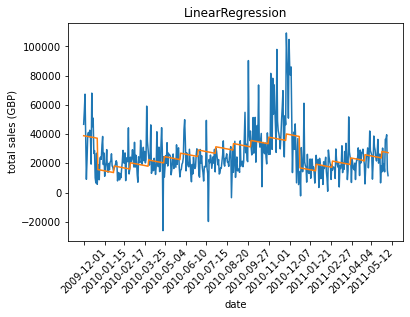

In [28]:
import matplotlib.dates as mdates
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train)
ax.plot(X_train_axis.index,preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title("LinearRegression")
plt.show()


In [29]:
#test set 
# predict on the same period
test_preds = my_lr.predict(X_test)
mape = mean_absolute_percentage_error(y_test,test_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.6712999325673368


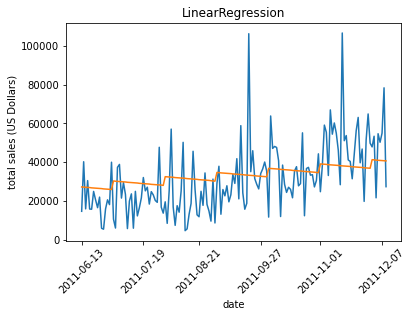

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test)
ax.plot(X_test_axis.index,test_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (US Dollars)")
plt.title("LinearRegression")
plt.show()

Comment: Linear Regression is have some limitation to this data so the model has low learning ability

In [31]:
from sklearn.ensemble import RandomForestRegressor

# fit the model
my_rf = RandomForestRegressor(n_estimators =100, max_depth=80, random_state=0)
my_rf.fit(X_train, y_train)

# predict on the same period
rf_preds = my_rf.predict(X_train)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_train,rf_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.19628545620982807


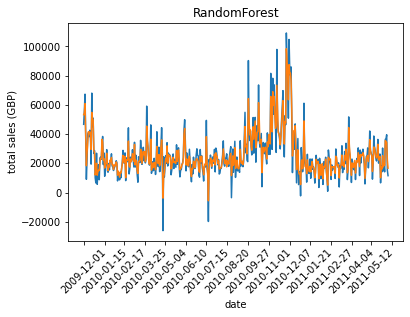

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train)
ax.plot(X_train_axis.index,rf_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('RandomForest')
plt.show()

Test set

In [33]:
# predict on the same period
test_rf_preds = my_rf.predict(X_test)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_test,test_rf_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.53148138025058


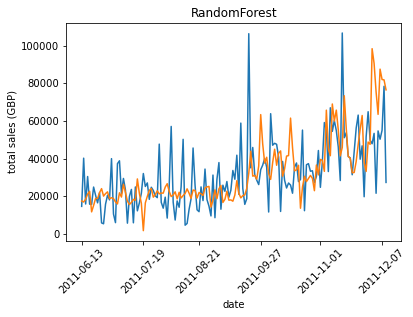

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test)
ax.plot(X_test_axis.index,test_rf_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('RandomForest')
plt.show()

XGBOOST

In [41]:
pip install xgboost

  Using cached xgboost-1.7.3-py3-none-win_amd64.whl (89.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [42]:
import xgboost as xgb

# fit the model
my_xgb = xgb.XGBRegressor(max_depth = 10)
my_xgb.fit(X_train,y_train)

# predict on the same period
xg_preds = my_xgb.predict(X_train)

#mae
mape = mean_absolute_percentage_error(y_train,xg_preds)
print('mean absolute percentage error:',mape)


mean absolute percentage error: 0.00015553709501628927


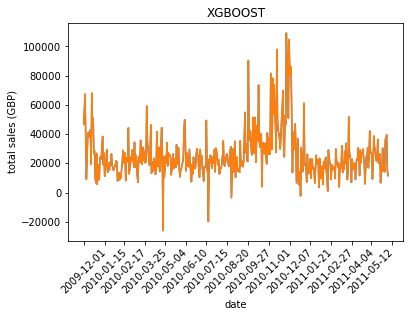

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_train_axis.index,y_train)
ax.plot(X_train_axis.index,xg_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('XGBOOST')
plt.show()

In [44]:
# predict on the same period
test_xg_preds = my_xgb.predict(X_test)
# plot what has been learned
#plt.plot(daily_resampled.index, y)
#plt.plot(daily_resampled.index, rf_preds)
mape = mean_absolute_percentage_error(y_test,test_xg_preds)
print('mean absolute percentage error:',mape)

mean absolute percentage error: 0.5477189689176009


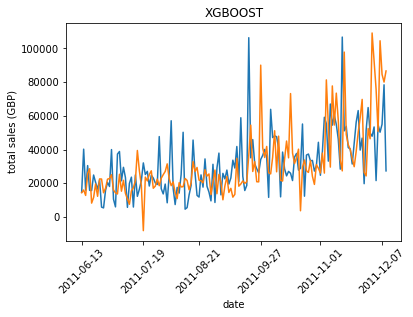

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(X_test_axis.index,y_test)
ax.plot(X_test_axis.index,test_xg_preds)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel("date")
plt.ylabel("total sales (GBP)")
plt.title('XGBOOST')
plt.show()

Comment: 



XGBOOST model has the lowest mean absolute error during the training.
We can see that the peak of total sales from 3 models prediction is around the end of the year or November-December which is correlate with the EDA we performed earlier. 

In [48]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


# SARIMA Model

In [64]:
#SARIMA Model
import warnings
import itertools
import statsmodels.api as sm
import pmdarima as pm

param=(2,1,3)
param_seasonal=(2,1,3,12)

mod = sm.tsa.statespace.SARIMAX(y_train, order=param, seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(2, 1, 3)x(2, 1, 3, 12)12 - AIC:8721.451947437155


In [66]:
#Let's fit the model to our data
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 1),
                                seasonal_order=(2, 1, 0, 12))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 10.674829
         Iterations: 2
         Function evaluations: 97
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6706      0.033    -20.126      0.000      -0.736      -0.605
ar.S.L12      -0.6280      0.037    -16.896      0.000      -0.701      -0.555
ar.S.L24      -0.2726      0.037     -7.363      0.000      -0.345      -0.200
sigma2      2.062e+08   6.56e-11   3.15e+18      0.000    2.06e+08    2.06e+08


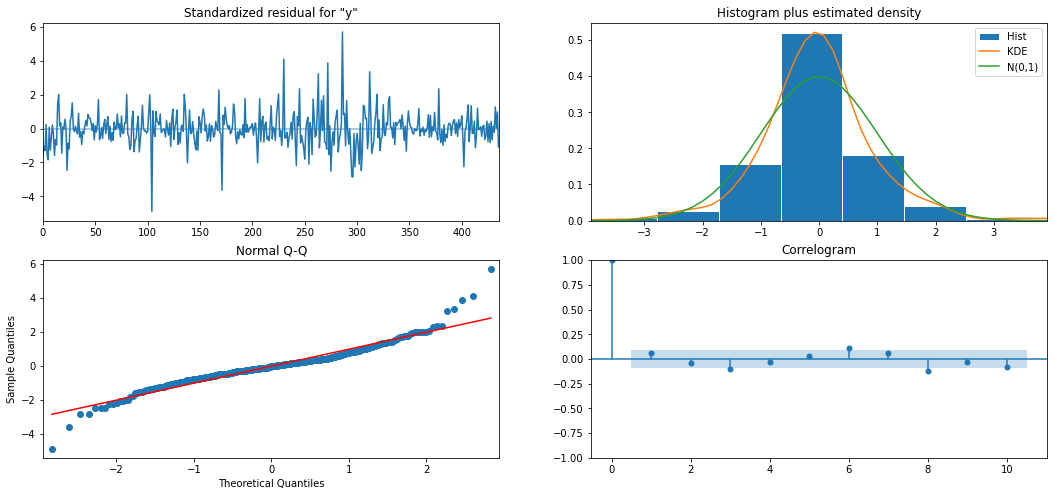

In [67]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

Hence, we can tell that the residuals are uncorrelated and that they have zero mean. So the model is properly fitted.